## Try to get time iteration direct working

We want the possibility of using time iteration direct because it is much faster than time iteration, which will speed up the computation of equilibrium massively. 

In [1]:
# Setup
import numpy as np
import scipy.sparse as spa

from dolo import yaml_import
from dolo.algos.dtcscc.time_iteration import time_iteration, time_iteration_direct
import dolo.algos.dtcscc.distributions_general as dst
from dolo.numeric.misc import mlinspace
from dolo.numeric.discretization.quadrature import gauss_hermite_nodes
from dolo.numeric.discretization.discretization import rouwenhorst


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
filename = 'incomplete_markets_dtcscc.yaml'
model = yaml_import(filename)

# model2 = yaml_import('rbc_full.yaml')

Nf = np.array([100, 9])

### Solve using time iteration and plot decision rules

In [4]:
dr = time_iteration_direct(model,with_complementarities=True, verbose=False)

In [96]:
# dr2 = time_iteration_direct(model2,with_complementarities=True, verbose=True)
# dr2 = time_iteration(model2,with_complementarities=True, verbose=True)

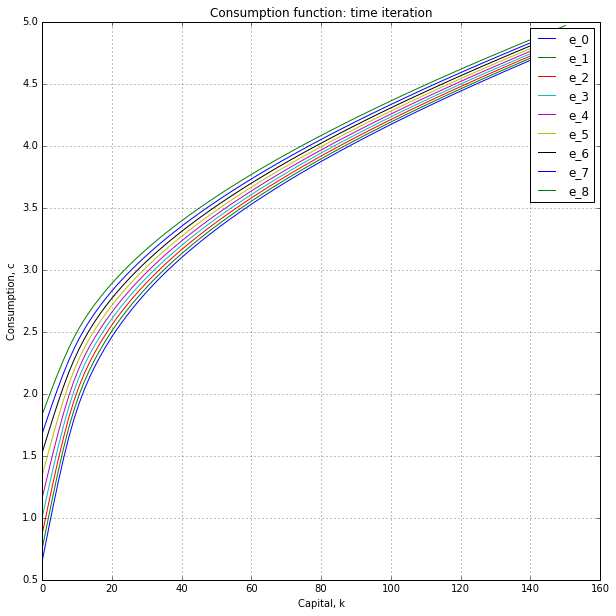

In [5]:

Nk = 100
Nftmp = np.array([Nk,1])
egrid = np.unique(dr.grid[:,1])
Ne = egrid.shape[0]

drc = np.zeros([Nk, Ne])
# drc_direct = np.zeros([Nk, Ne])
for i_e in range(Ne):
    sgridf = mlinspace(np.array([min(dr.grid[:,0]), egrid[i_e]]), np.array([max(dr.grid[:,0]), egrid[i_e]]),Nftmp)
    drc[:, i_e] = dr(sgridf).flatten()
#     drc_direct[:, i_e] = dr_direct(sgridf).flatten()

%matplotlib inline

plt.figure(figsize=(10, 10))
for i_e in range(Nf[1]):
    plt.plot(sgridf[:,0], drc[:,i_e],label='e_'+str(i_e))
plt.ylabel('Consumption, c')
plt.xlabel('Capital, k')
plt.title('Consumption function: time iteration')
plt.legend()
plt.grid()


### Compute stationary distribution 

In [6]:
L, QT = dst.stat_dist(model, dr, Nf, itmaxL=5000, tolL=1e-8, verbose=True)

Iteration = 0, dist = 0.280184 

Iteration = 100, dist = 0.006572 

Iteration = 200, dist = 0.000394 

Iteration = 300, dist = 0.000018 

Iteration = 400, dist = 0.000001 

Iteration = 500, dist = 0.000000 



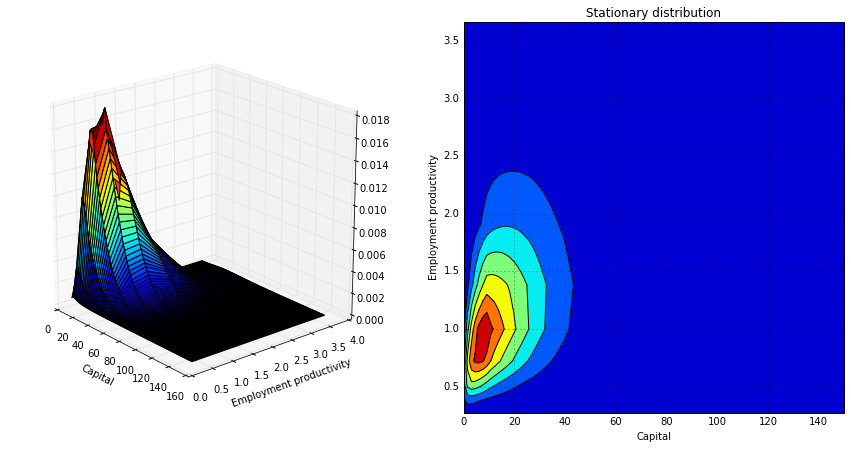

In [7]:
# 3D plot of the distribution
Nkf = Nf[0]
Nef = Nf[1]
Z = L.reshape([Nef, Nkf],order='F')    # Need Fortran order since variables are in a different order
sgridf = dst.fine_grid(model, Nf)
kgridf = np.unique(sgridf[:,0])
egridf = np.unique(sgridf[:,1])
# kgridf, egridf = dst.fine_grid(model, Nf)
X, Y = np.meshgrid(kgridf, np.exp(egridf))

fig = plt.figure(figsize=(15, 7))
# plt.subplot(121)
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap = cm.jet)
plt.xlabel('Capital')
plt.ylabel('Employment productivity')
ax.elev = 20
ax.azim = 320

ax = fig.add_subplot(122)
contour = plt.contour(X, Y, Z, colors='k')
cp = plt.contourf(X, Y, Z)
plt.title('Stationary distribution')
plt.xlabel('Capital')
plt.ylabel('Employment productivity')
plt.grid()
plt.show()

### Bisection

Note, this is WAY too unstable. Cannot find an equilibrium this way...

In [31]:
# def eqm_bisection(model, Nf, bounds, itermaxKeq=100, tolKeq=1e-4, verbose=False):
pricenames = ['r']
varnames = [['k','kagg']]
bounds = [[0.02, 0.035]]
numprice = len(pricenames)
Nmax = 100
tol = 1e-2

a = bounds[numprice-1][0]
b = bounds[numprice-1][1]

n=0
while n <= Nmax:
    c = (a + b)/2
    
    # get resid at c
    model.set_calibration(r=c)
    dr = time_iteration_direct(model,with_complementarities=True, verbose=False)
    L, QT = dst.stat_dist(model, dr, Nf, itmaxL=5000, tolL=1e-8, verbose=False)
    c_resid = dst.get_aggregates(model, dr, Nf, L, 'k', 'kagg')
    
    # get resid at a
    model.set_calibration(r=a)
    dr = time_iteration_direct(model,with_complementarities=True, verbose=False)
    L, QT = dst.stat_dist(model, dr, Nf, itmaxL=5000, tolL=1e-8, verbose=False)
    a_resid = c_resid = dst.get_aggregates(model, dr, Nf, L, 'k', 'kagg')
    
    if np.abs(c_resid) < tol:
        break
    n += 1
    if np.sign(c_resid) == np.sign(a_resid):
        a = c
    else:
        b =c
    print('This is iteration %i\n' % n)
    print('Resid at midpoint = %f\n' % c_resid)


# K = Kinit
# model.set_calibration(kagg=K)
# if ('direct_response' in model.symbolic.equations):
#     dr = time_iteration_direct(model, with_complementarities=True, verbose=False)
# else:
#     dr = time_iteration(model, with_complementarities=True, verbose=False)

    There are multiple convergent solutions. The one with the smaller eigenvalues was selected.


This is iteration 1

Resid at midpoint = 75.046691

This is iteration 2

Resid at midpoint = 33.017996

This is iteration 3

Resid at midpoint = 12.637701

This is iteration 4

Resid at midpoint = -7.068957

This is iteration 5

Resid at midpoint = -27.435327

This is iteration 6

Resid at midpoint = -99.448626

This is iteration 7

Resid at midpoint = -51.250337

This is iteration 8

Resid at midpoint = -55.732618

This is iteration 9

Resid at midpoint = -110.377659

This is iteration 10

Resid at midpoint = -59.115047

This is iteration 11

Resid at midpoint = -110.638164

This is iteration 12

Resid at midpoint = -59.960063

This is iteration 13

Resid at midpoint = -60.100805

This is iteration 14

Resid at midpoint = -60.171145

This is iteration 15

Resid at midpoint = -60.206333

This is iteration 16

Resid at midpoint = -110.714657

This is iteration 17

Resid at midpoint = -110.715865

This is iteration 18

Resid at midpoint = -110.716467

This is iteration 19

Resid at midpo

KeyboardInterrupt: 

In [29]:
np.sign?

In [27]:
model.set_calibration(r=0.025)
dr = time_iteration_direct(model,with_complementarities=True, verbose=False)
L, QT = dst.stat_dist(model, dr, Nf, itmaxL=5000, tolL=1e-8, verbose=False)
dst.get_aggregates(model, dr, Nf, L, 'k', 'kagg')

44.964593602300255

In [19]:
Kd, Ks, r = dst.supply_demand(model, 'kagg', 'r', Nf, lower=0.02, upper=0.035, numpoints=30, verbose=False)


    There are multiple convergent solutions. The one with the smaller eigenvalues was selected.


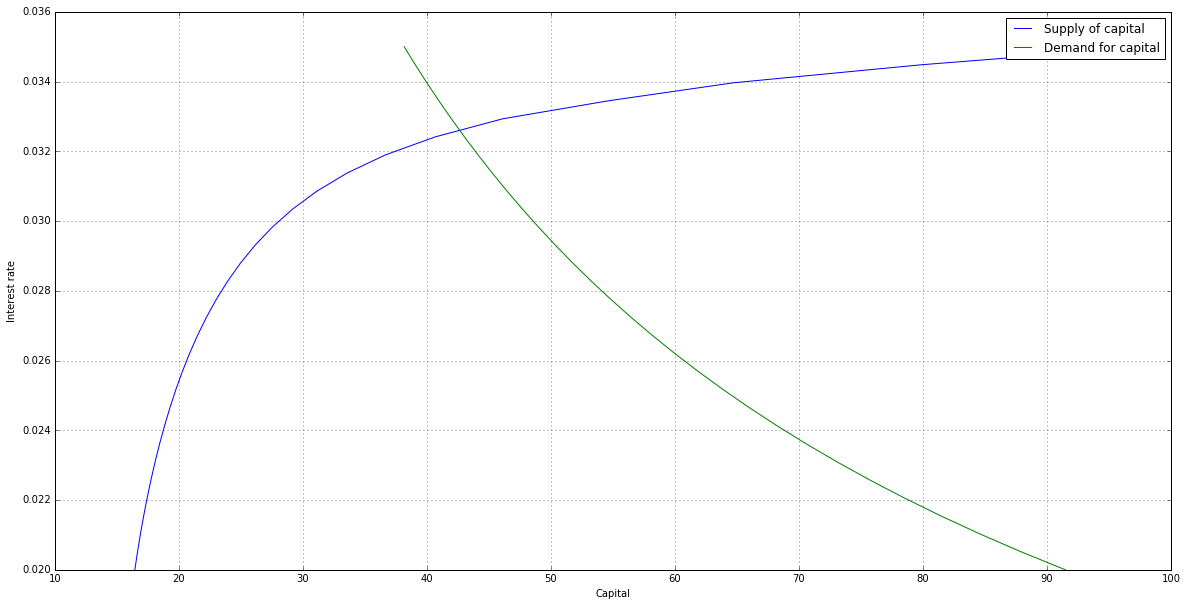

In [20]:
%matplotlib inline

fig = plt.figure(figsize=(20, 10))
plt.plot(Ks, r,label='Supply of capital')
plt.plot(Kd, r,label='Demand for capital')
# plt.plot((37.9893, 37.9893), (0.031, 0.036), 'k-', color='black', label='RA steady state capital')
plt.xlabel('Capital')
plt.ylabel('Interest rate')
plt.legend()
plt.grid()
# plt.ylim(0.027, 0.034)
# plt.xlim(20, 70)

In [ ]:
# def solve_eqm(model, Nf, Kinit=50, itermaxKeq=100, tolKeq=1e-4, verbose=False):
Kinit=50
itermaxKeq=100
tolKeq=1e-4
verbose=False

K = Kinit
model.set_calibration(kagg=K)
if ('direct_response' in model.symbolic.equations):
    dr = time_iteration_direct(model, with_complementarities=True, verbose=False)
else:
    dr = time_iteration(model, with_complementarities=True, verbose=False)

sgridf = fine_grid(model, Nf)

damp = 0.999
for iteq in range(itermaxKeq):
    # Solve for decision rule given current guess for K
    if ('direct_response' in model.symbolic.equations):
        dr = time_iteration_direct(model, with_complementarities=True, verbose=False)
    else:
        dr = time_iteration(model, with_complementarities=True, verbose=False)

    # Solve for stationary distribution given decision rule
    L, QT = stat_dist(model, dr, Nf, verbose=False)
    Kagg = np.dot(L, sgridf[:,0])

    dK = np.linalg.norm(Kagg-K)/K
    if (dK < tolKeq):
        break

    if verbose is True:
        print('Iteration = \t%i: K=\t%1.4f  Kagg=\t%1.4f\n' % (iteq, K, Kagg) )

    # Update guess for aggregate capital using damping
    K = damp*K + (1-damp)*Kagg

    # Update calibration and reduce damping paramter
    model.set_calibration(kagg=K)
    damp = 0.995*damp


### Compute the equilibrium interest rate 


In [33]:
K = dst.solve_eqm(model, Nf, Kinit=40, tolKeq=1e-4, verbose=True)

Iteration = 	0: K=	40.0000  Kagg=	73.7806

Iteration = 	1: K=	40.0338  Kagg=	64.1676

Iteration = 	2: K=	40.1785  Kagg=	62.2757

Iteration = 	3: K=	40.4208  Kagg=	59.3453

Iteration = 	4: K=	40.7219  Kagg=	57.6107

Iteration = 	5: K=	41.0737  Kagg=	52.7573

Iteration = 	6: K=	41.3742  Kagg=	50.2654

Iteration = 	7: K=	41.6463  Kagg=	48.4516

Iteration = 	8: K=	41.8875  Kagg=	46.7568

Iteration = 	9: K=	42.0836  Kagg=	45.4248

Iteration = 	10: K=	42.2342  Kagg=	44.5524

Iteration = 	11: K=	42.3497  Kagg=	43.9622

Iteration = 	12: K=	42.4377  Kagg=	43.4453

Iteration = 	13: K=	42.4975  Kagg=	43.1350

Iteration = 	14: K=	42.5383  Kagg=	42.9596

Iteration = 	15: K=	42.5673  Kagg=	42.7809

Iteration = 	16: K=	42.5829  Kagg=	42.7025

Iteration = 	17: K=	42.5923  Kagg=	42.6560

Iteration = 	18: K=	42.5975  Kagg=	42.6299

Iteration = 	19: K=	42.6003  Kagg=	42.6159

Iteration = 	20: K=	42.6018  Kagg=	42.6088

Iteration = 	21: K=	42.6024  Kagg=	42.6343

Iteration = 	22: K=	42.6057  Kagg=	42.5895

### Using equilibrium aggregate capital stock, compute decision rules and stationary distribution

In [34]:
model.set_calibration(kagg=K)
dr = time_iteration_direct(model, with_complementarities=True, verbose=False) 
L, QT = dst.stat_dist(model, dr, Nf, itmaxL=5000, tolL=1e-8, verbose=True)

Iteration = 0, dist = 0.275975 

Iteration = 100, dist = 0.003141 

Iteration = 200, dist = 0.001677 

Iteration = 300, dist = 0.000842 

Iteration = 400, dist = 0.000399 

Iteration = 500, dist = 0.000186 

Iteration = 600, dist = 0.000086 

Iteration = 700, dist = 0.000040 

Iteration = 800, dist = 0.000018 

Iteration = 900, dist = 0.000009 

Iteration = 1000, dist = 0.000004 

Iteration = 1100, dist = 0.000002 

Iteration = 1200, dist = 0.000001 

Iteration = 1300, dist = 0.000000 

Iteration = 1400, dist = 0.000000 

Iteration = 1500, dist = 0.000000 

Iteration = 1600, dist = 0.000000 

Iteration = 1700, dist = 0.000000 



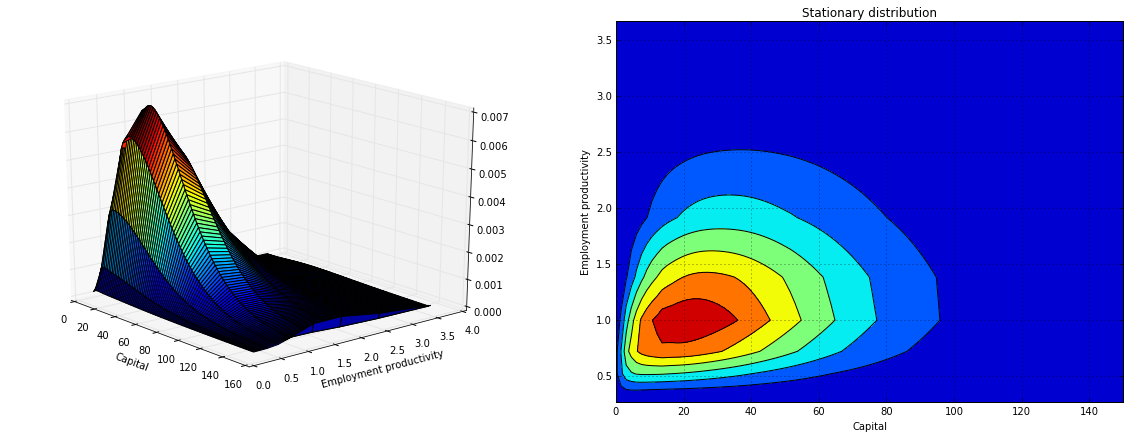

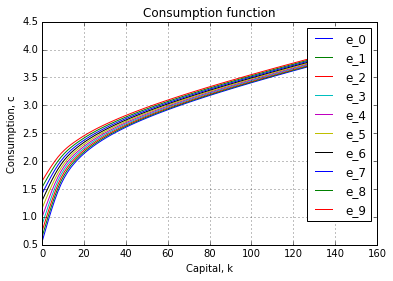

In [35]:
# 3D plot of the distribution
Nkf = Nf[0]
Nef = Nf[1]
Z = L.reshape([Nef, Nkf],order='F')    # Need Fortran order since variables are in a different order
sgridf = dst.fine_grid(model, Nf)
kgridf = np.unique(sgridf[:,0])
egridf = np.unique(sgridf[:,1])
# kgridf, egridf = dst.fine_grid(model, Nf)
X, Y = np.meshgrid(kgridf, np.exp(egridf))

fig = plt.figure(figsize=(20, 15))
# plt.subplot(121)
ax = fig.add_subplot(221, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap = cm.jet)
plt.xlabel('Capital')
plt.ylabel('Employment productivity')
ax.elev = 20
ax.azim = 320

ax = fig.add_subplot(222)
contour = plt.contour(X, Y, Z, colors='k')
cp = plt.contourf(X, Y, Z)
plt.title('Stationary distribution')
plt.xlabel('Capital')
plt.ylabel('Employment productivity')
plt.grid()
plt.show()



Nk = 100
Nftmp = np.array([Nk,1])
egrid = np.unique(dr.grid[:,1])
Ne = egrid.shape[0]

drc = np.zeros([Nk, Ne])
for i_e in range(Ne):
    sgridf = mlinspace(np.array([min(dr.grid[:,0]), egrid[i_e]]), np.array([max(dr.grid[:,0]), egrid[i_e]]),Nftmp)
    drc[:, i_e] = dr(sgridf).flatten()

ax = fig.add_subplot(223)
for i_e in range(10):
    plt.plot(sgridf[:,0], drc[:,i_e],label='e_'+str(i_e))
plt.ylabel('Consumption, c')
plt.xlabel('Capital, k')
plt.title('Consumption function')
plt.legend()
plt.grid()

### Plot the equilibrium stationary distribution and decision rules

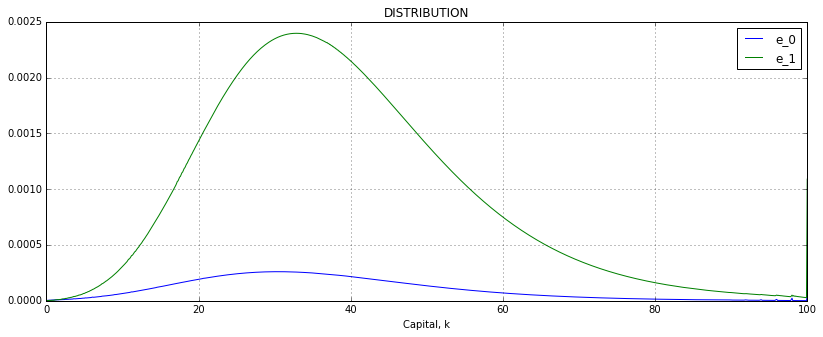

In [6]:
%matplotlib inline

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(kgridf, L[:Nkf],label='e_0')
plt.plot(kgridf, L[Nkf:],label='e_1')
plt.xlabel('Capital, k')
plt.title('DISTRIBUTION')
plt.legend()
plt.grid()

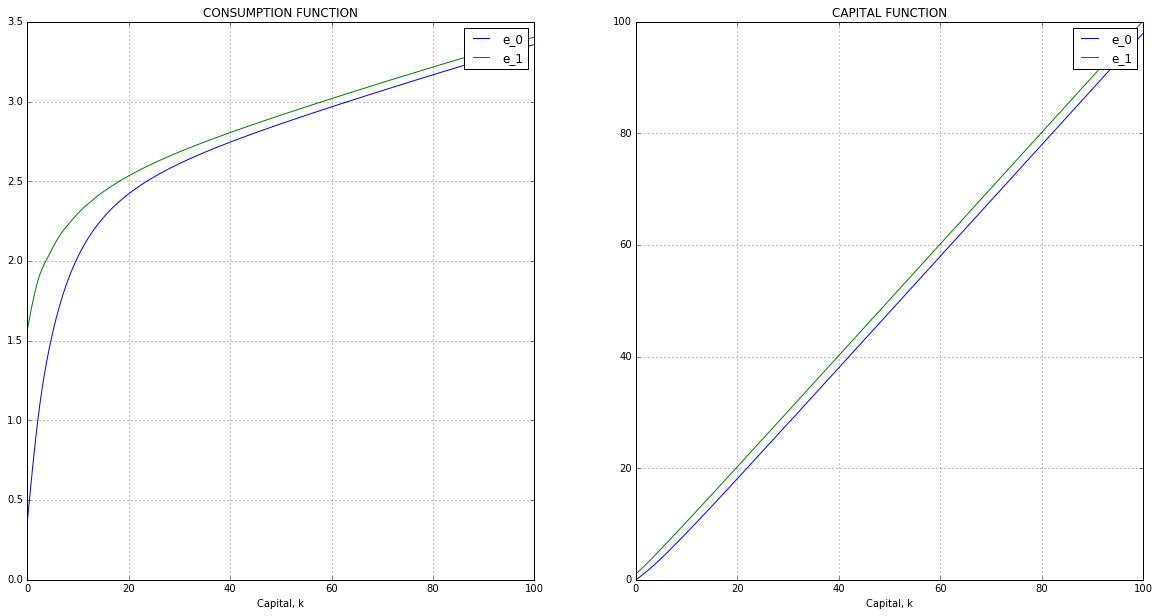

In [9]:
# Get kprime and consumption from the markov decision rule

kprimef = dst.mdr_to_sprime(model, mdr, Nkf)
mdrc = np.zeros([Nkf, Ne])
for i_m in range(Ne):
    mdrc[:, i_m] = mdr(i_m, kgridf.reshape(-1,1)).flatten()

# Plot controls

%matplotlib inline
kgrid = mdr.grid

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.plot(kgridf, mdrc[:,0],label='e_0')
plt.plot(kgridf, mdrc[:,1],label='e_1')
plt.xlabel('Capital, k')
plt.title('CONSUMPTION FUNCTION')
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(kgridf, kprimef[:Nkf],label='e_0')
plt.plot(kgridf, kprimef[Nkf:],label='e_1')
plt.xlabel('Capital, k')
plt.title('CAPITAL FUNCTION')
plt.legend()
plt.grid()

### Compute supply and demand curves using stat_dist function

In [ ]:
Kd, Ks, r = dst.supply_demand(model, Nkf=1000, numpoints=20, lower=37, upper=40, verbose=True)

(20, 60)

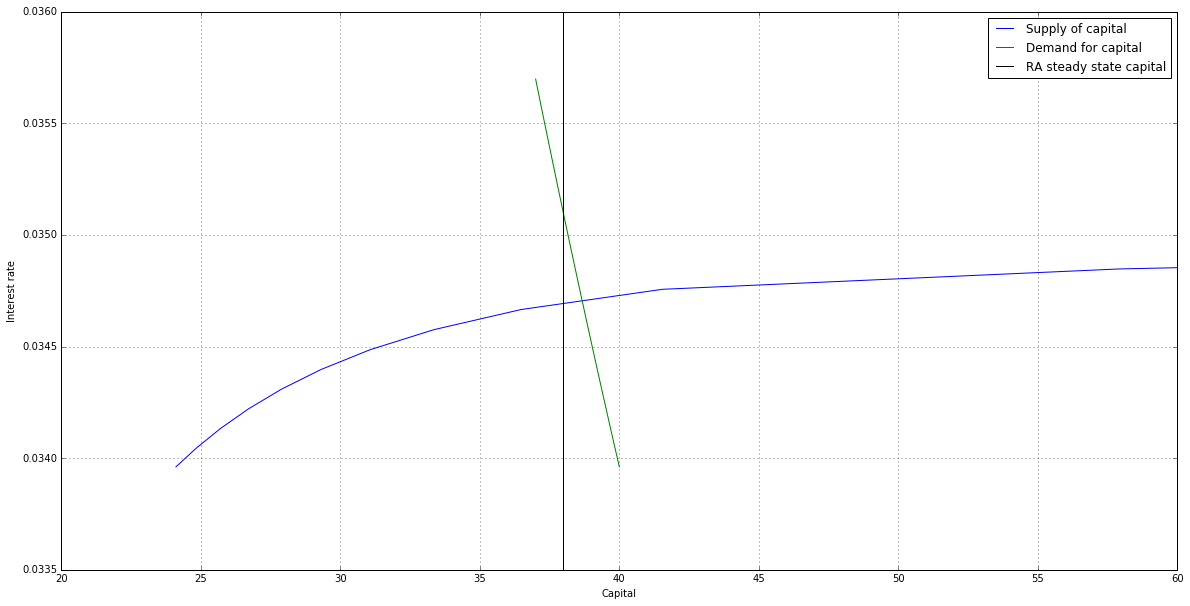

In [4]:
%matplotlib inline

fig = plt.figure(figsize=(20, 10))
plt.plot(Ks, r,label='Supply of capital')
plt.plot(Kd, r,label='Demand for capital')
plt.plot((37.9893, 37.9893), (0.031, 0.036), 'k-', color='black', label='RA steady state capital')
plt.xlabel('Capital')
plt.ylabel('Interest rate')
plt.legend()
plt.grid()
plt.ylim(0.0335, 0.036)
plt.xlim(20, 60)

#### Create a function that takes transition back to control

For models in which we can use the $s_{t+1}$ trick, need to create a function that takes this transition rule back to the control. 